### 1. Problem statement
- you have been tasked to automate the process of detecting and classifying chest disease and reduce the cost and time of detection. 
- The team has collected extensive X-Ray chest data and they approached you to develop a model that could detect and classify the diseases in less than 1 minute. 
- You have been provided with 133 images that belong to 4 classes: 
 - Healthy 
 - Covid-19
 - Bacterial Pneumonia
 - Viral Pneumonia 


### 2. Import library

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, SeparableConv2D
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
# from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

import random 
random.seed(0)

# Set the numpy seed
np.random.seed(0)

# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(0)

sess_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, 
                            inter_op_parallelism_threads = 1)

sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = sess_config)
# sess = tf.Session(graph = tf.compat.v1.get_default_graph(), config = sess_config)
tf.compat.v1.keras.backend.set_session(sess)
# K.tensorflow_backend.set_session(sess)

### 3. Read & Prepare data

- This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
-  Each class contains 133 images.
-  Dataset Source:
 - https://github.com/ieee8023/covid-chestxray-dataset 
 -  https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [3]:
train_data_dir = os.path.join(os.getcwd(), 'Train')

use image generator to generate tensor image data and normalize them

In [4]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

- generate batches of 40 images  
- total number of images are 133*4 = 532
- training is 80% and valiation is 20%
- perform shuffling and reszing

In [5]:
train_gen = image_generator.flow_from_directory(batch_size = 40, 
                                                      directory= train_data_dir, 
                                                      shuffle = True, 
                                                      target_size = (256, 256), #pixel size
                                                      class_mode = 'categorical', #categorical classfication
                                                      subset= 'training',
                                                       seed = 0)

Found 428 images belonging to 4 classes.


In [6]:
validation_gen = image_generator.flow_from_directory(batch_size = 40, 
                                                      directory= train_data_dir, 
                                                      shuffle = True, 
                                                      target_size = (256, 256), #pixel size
                                                      class_mode = 'categorical', #categorical classfication
                                                      subset= 'validation', 
                                                     seed = 0)

Found 104 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_gen)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 4)

In [10]:
label_names = {0: 'Covid19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### 4. Data visualization

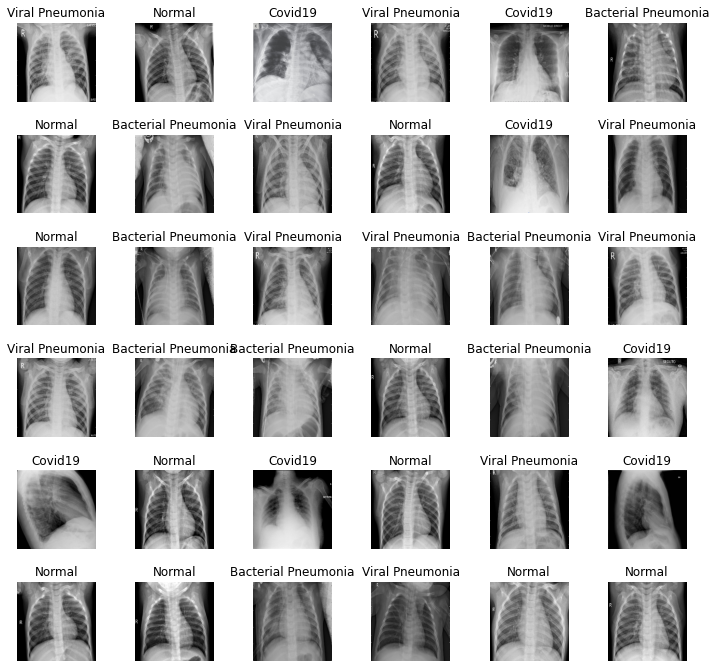

In [11]:
l = 6
w = 6
fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel() #flatten axis

for i in np.arange(0, l*w):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')


plt.subplots_adjust(wspace = 0.5)

### 5. Import pre-trained model

#### Vanishing gradient
- Vanishing gradient: as CNN grows deeper, vanishing gradient occurs. 
- It occurs when the gradient is back-propagated to earlier layers which results in small gradients.  
- Residual Neural Network includes 'skip-connection' feature which enable training of vert deep models without gadient vanishing.
- ImageNet contain 11 million images and 11000 categories
- ImageNet is used to train ResNet 

#### Transfer learning
 - copy and freeze the middle feature layers  
 - train with new data  
 - create new custom layers at the end to perform classification on specific task

 - model trained with imagenet dataset 
 - no classification head
 - input in shape of cutom image size
<!--  - 50 layers deep  -->

In [12]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

# basemodel = InceptionV3(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [13]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [14]:
#freeze the layers in bottom
for layer in basemodel.layers[: -10]:
    layer.trainable = False

### 6. Create & Train model

In [15]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)

headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(256, activation = "relu")(headmodel)
# headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.4)(headmodel)

headmodel = Dense(128, activation = "relu")(headmodel)
# headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.4)(headmodel)

headmodel = Dense(64, activation = "relu")(headmodel)
# headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.4)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [17]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.RMSprop(lr = 1e-4, decay = 1e-6), 
              metrics = [f1, 'accuracy'])

In [18]:
#use early stopping to monitor validation loss, stop if val_loss not decreasing after certain number of epochs
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)

#save the model with lowest val_loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdfs', verbose = 1, save_best_only=True)

keras issue 5862

In [19]:
#--0.6 darken image, 1.2 bright img
#--zoom 0.8 make object bigger
train_gen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
                                
train_generator = train_gen.flow_from_directory(batch_size=8, 
                                                     directory=train_data_dir,
                                                     shuffle=True, 
                                                      target_size=(256, 256),
                                                     class_mode='categorical',
                                                      subset = 'training',
                                                      seed = 0
                                                     )

Found 428 images belonging to 4 classes.


In [20]:
val_gen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
val_generator = val_gen.flow_from_directory(batch_size=8, 
                                                     directory=train_data_dir,
                                                     shuffle=True, 
                                                      target_size=(256, 256),
                                                     class_mode='categorical',
                                                      subset = 'validation',
                                                    seed = 0
                                                     )

Found 104 images belonging to 4 classes.


In [21]:
train_generator.n, val_generator.n 

(428, 104)

In [22]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n // 8, 
                              epochs = 20, 
                              validation_data= val_generator, 
                              validation_steps= val_generator.n // 8, 
                              callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
53/53 [==============================] - ETA: 0s - loss: 1.5960 - f1: 0.1248 - accuracy: 0.2810
Epoch 00001: val_loss improved from inf to 1.41633, saving model to weights.hdfs
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights.hdfs\assets
53/53 [==============================] - 308s 6s/step - loss: 1.5960 - f1: 0.1248 - accuracy: 0.2810 - val_loss: 1.4163 - val_f1: 0.0000e+00 - val_accuracy: 0.2500
Epoch 2/20
53/53 [==============================] - ETA: 0s - loss: 1.4403 - f1: 0.0688 - accuracy: 0.2738
Epoch 00002: val_loss improved from 1.41633 to 1.33440, saving model to weights.hdfs
INFO:tensorflow:Assets written to: weights.hdfs\assets
53/53 [=============================

### 7. Evaluate model

In [23]:
history.history.keys()

dict_keys(['loss', 'f1', 'accuracy', 'val_loss', 'val_f1', 'val_accuracy'])

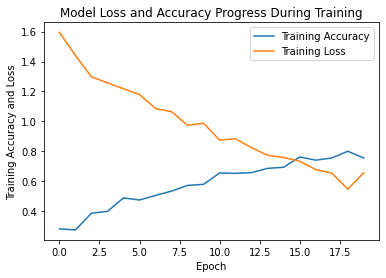

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])


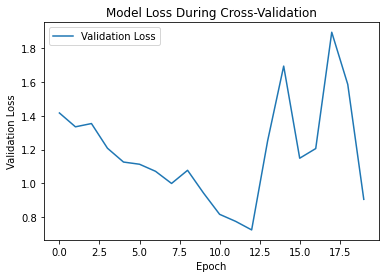

In [25]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

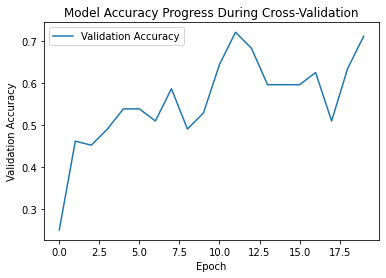

In [26]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [27]:
test_dir = os.path.join(os.getcwd(), 'Test')

In [28]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 4, 
                                             directory = test_dir, 
                                             shuffle = True,
                                             target_size = (256, 256),
                                              class_mode = 'categorical',
                                              seed = 0
                                             )

Found 40 images belonging to 4 classes.


In [29]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose = 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
10/10 [==============================] - 14s 1s/step - loss: 1.3577 - f1: 0.6595 - accuracy: 0.6500


In [30]:
print('Accuracy during test: {}'.format(evaluate[1]))

Accuracy during test: 0.6595237255096436


In [31]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_dir))):
  for item in os.listdir(os.path.join(test_dir,str(i))):
    img= cv2.imread(os.path.join(test_dir,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [32]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))


Test Accuracy : 0.65


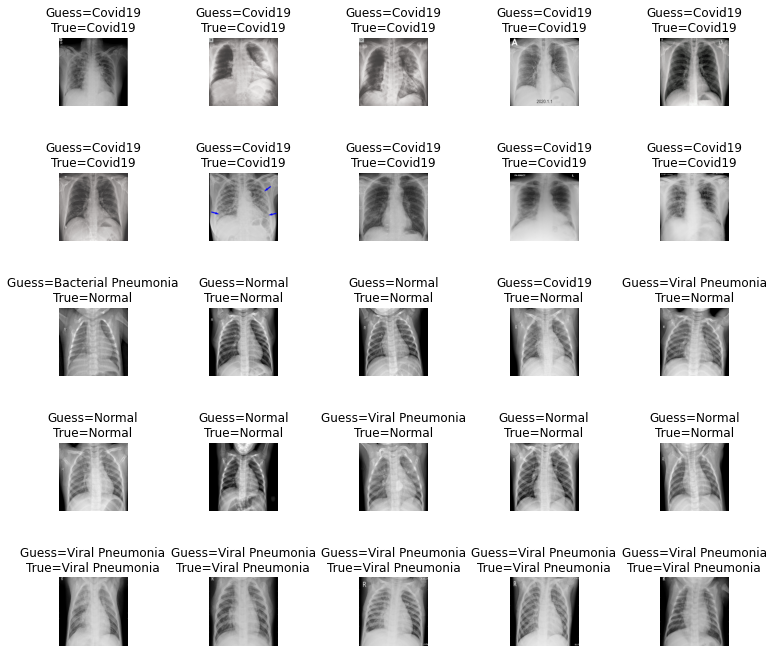

In [33]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [34]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.67      0.60      0.63        10
           2       0.71      0.50      0.59        10
           3       0.62      0.50      0.56        10

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.64        40
weighted avg       0.66      0.65      0.64        40



Text(33.0, 0.5, 'Original')

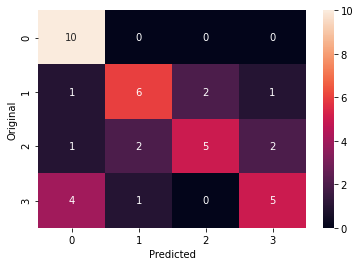

In [35]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')